# FGSM

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import os
import torch
import torchvision
import torchvision.transforms as transformss
from sklearn.preprocessing import LabelEncoder
from six.moves import urllib
import matplotlib.pyplot as plt
import numpy as np
import math

/home/han/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/han/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [6]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU
device = "cpu"

classes = [
    'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 
    'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 
    'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 
    'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 
    'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 
    'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 
    'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 
    'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 
    'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 
    'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 
    'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 
    'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 
    'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 
    'stapler', 'starfish', 'stegosaurus', 'stop_sign', 'strawberry', 'sunflower', 
    'tick', 'trilobite', 'umbrella', 'watch', 'water_lilly', 'wheelchair', 
    'wild_cat', 'windsor_chair', 'wrench', 'yin_yang'
]
len(classes)

101

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import pretrainedmodels

# the resnet34 model
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained = None)
        # change the classification layer
        self.l0= nn.Linear(512, len(classes))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.dropout(x)
        l0 = self.l0(x)
        return l0

In [42]:
PATH = '../Classify/caltech101_net.pth'
net = ResNet34(False)
if device == "cpu":
    net.load_state_dict(torch.load(PATH, map_location='cpu'))
else:
    net.load_state_dict(torch.load(PATH))

net.eval()

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [113]:
from PIL import Image

transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img = Image.open("./img/an225.jpg")
image = transform(img)
images = image.unsqueeze(0)
label = torch.tensor(classes.index("airplanes"))
labels = label.unsqueeze(0)

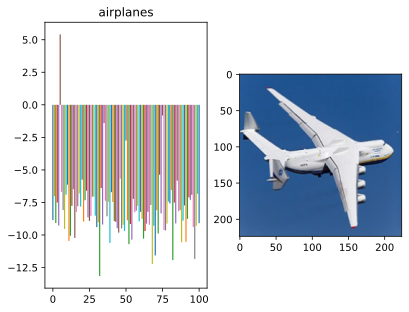

In [145]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
classes[predicted.item()]

plt.subplot(1,2,1)
for i in range(101):
    plt.bar(i,outputs[0][i].item())
plt.title(classes[predicted.item()])
plt.subplot(1,2,2)
img = images / 2 + 0.5  
npimg = img.detach().numpy()
plt.imshow((np.transpose(npimg[0], (1, 2, 0))))
plt.savefig(f'./out/before.svg')
plt.show()

In [130]:
eps = 0.01

In [142]:
def fgsm(net, loss, images, labels, eps):
    
    images = images.to(device)
    labels = labels.to(device)
    images = images.detach()
    images.requires_grad = True
    
    outputs = net(images)
    net.zero_grad()
    cost = loss(outputs, labels).to(device)
    cost.backward()
    pertabation = eps*images.grad.sign()
    attack_images = images + pertabation
    attack_images = torch.clamp(attack_images, -1,1)
    
    return attack_images, pertabation
    

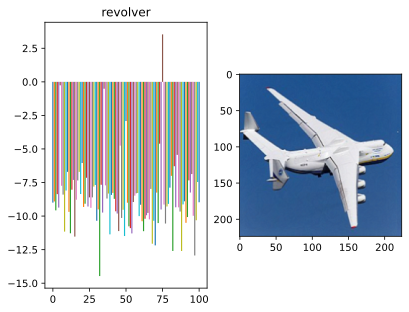

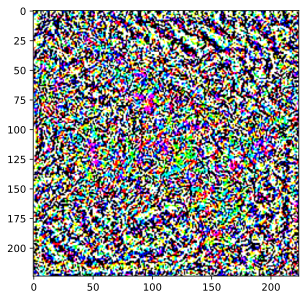

In [147]:
loss = nn.CrossEntropyLoss()
images_before = images
images_after, pertabation = fgsm(net, loss, images, labels, eps)
images_after = images_after.to(device)
labels = labels.to(device)
outputs = net(images_after)

_, pre = torch.max(outputs.data,1)




plt.subplot(1,2,1)
for i in range(101):
    plt.bar(i,outputs[0][i].item())
plt.title(classes[pre.item()])
plt.subplot(1,2,2)
img = images_after / 2 + 0.5  
npimg = img.detach().numpy()
plt.imshow((np.transpose(npimg[0], (1, 2, 0))))
plt.savefig(f'./out/after.svg')
plt.show()


plt.imshow(np.transpose(
            torchvision.utils.make_grid(
                pertabation.cpu().data, normalize=True
            ).numpy(),(1,2,0)))
plt.savefig(f'./out/pertabation.png')
plt.show()
